In [1]:
import mne
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
import os
import re

# Multiprocessing
import deepgraph as dg
from multiprocessing import Pool

import torch


In [2]:
%matplotlib inline
cmap = sns.cm.rocket_r

# Data Preparation

In [3]:
# Common functions
def get_eeg_file(unique_id): 
  rootdir = "./Data"
  sub,  taks = unique_id.split('_')
  regex = re.compile('(.*{}.*{}.*edf$)'.format(sub, taks))

  for root, dirs, files in os.walk(rootdir):
    for file in files:
      if regex.match(file):
        return file
      
def split_given_size(a, size):
    new_array =  np.array_split(a, np.arange(size,a.shape[1],size), axis=1)
    if(new_array[-1].shape[1] < new_array[0].shape[1]):
        new_array = new_array[:-1]
    return new_array

def get_raw_eeg(filename, root_dir = "./Data/"):
    raw = mne.io.read_raw_edf(root_dir + filename)
    return raw
#split_given_size(np.arange(1000),7)

In [4]:
def graph_corr_matrix(corr, channels):
    sns.heatmap(np.average(corr, axis=0), cmap=cmap, vmax=1, vmin=0, xticklabels=channels, yticklabels=channels)

In [42]:
df = pd.read_excel("Demographic_List.xlsx")

df.shape

(383, 9)

In [47]:
df.groupby("Condition").count()

,sub,Age,Gender,Study,count,session,task,Headset,unique_id,filename
Condition,,,,,,,,,,
AD,52,52,52,52,52,52,52,52,52,52
HC,224,224,224,224,224,224,224,224,224,224
MCI,107,107,107,107,107,107,107,107,107,107


In [44]:
conditions = set(df["Condition"])
conditions

{'AD', 'HC', 'MCI'}

In [45]:
# Preprocessing
df["unique_id"] = df["sub"].astype(str) + "_" + df["task"]
df["filename"] = df["unique_id"].apply(get_eeg_file)
#df = df[df["Condition"] != "AD"]

#df.to_csv("dataframe.csv")
df.head()

,sub,Age,Gender,Study,count,session,Condition,task,Headset,unique_id,filename
0,9003,41,F,INSPECDS,286,900301000,HC,RSEC,X24,9003_RSEC,INSPEC.INIT.900301000.010217.104300.Signals.Ra...
1,9003,41,F,INSPECDS,296,900301000,HC,RSEO,X24,9003_RSEO,INSPEC.INIT.900301000.010217.104300.Signals.Ra...
2,9004,66,F,INSPECDS,266,900401000,HC,RSEC,X24,9004_RSEC,INSPEC.INIT.900401000.070217.105622.Signals.Ra...
3,9004,66,F,INSPECDS,285,900401000,HC,RSEO,X24,9004_RSEO,INSPEC.INIT.900401000.070217.105622.Signals.Ra...
4,9006,52,M,INSPECDS,288,900601000,HC,RSEC,X24,9006_RSEC,INSPEC.INIT.900601000.130217.115256.Signals.Ra...


In [46]:
df.shape

(383, 11)

In [48]:
# Read EEG raw files and save them in a dict for later use 
raw_files = {} 
eeg_min_size = 308224
for _, s in df.iterrows(): 
    raw_files[s["unique_id"]] = get_raw_eeg(s["filename"])
    shape = raw_files[s["unique_id"]].get_data().shape[1] 
    eeg_min_size = shape if shape < eeg_min_size else eeg_min_size

eeg_min_size

Extracting EDF parameters from c:\Users\jimmy\Documents\CNU\EEG\Data\INSPEC.INIT.900301000.010217.104300.Signals.Raw_RSEC_01.edited.18.134.318.132.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\jimmy\Documents\CNU\EEG\Data\INSPEC.INIT.900301000.010217.104300.Signals.Raw_RSEO_01.edited.47.187.347.192.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\jimmy\Documents\CNU\EEG\Data\INSPEC.INIT.900401000.070217.105622.Signals.Raw_RSEC_01.edited.25.108.325.112.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\jimmy\Documents\CNU\EEG\Data\INSPEC.INIT.900401000.070217.105622.Signals.Raw_RSEO_01.edited.347.72.647.76.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\jimmy\Documen

285696

In [49]:
eeg_max_size = 1024
n_features = 20
n_samples = len(raw_files) 
channels = raw_files["9003_RSEC"].ch_names[:20]


_raw_files = raw_files.copy()


In [50]:
for key, value in raw_files.items(): 
    print(key)
    value.pick_channels(channels)
    #value.resample(512.)
    value.resample(512.)
    value.filter(l_freq=1., h_freq=100.)

    #asr = mne.preprocessing.ASR(sfreq=sample.info["sfreq"], cutoff=5, blocksize=value._data.shape[1])
    #asr.fit(value._data)
    #value._data = asr.transform(value._data)
    #break

9003_RSEC
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (3.303 sec)

9003_RSEO
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.

In [51]:
raw_files["9003_RSEC"]

<RawEDF | INSPEC.INIT.900301000.010217.104300.Signals.Raw_RSEC_01.edited.18.134.318.132.edf, 20 x 153600 (300.0 s), ~23.5 MB, data loaded>

In [52]:
raw_files["9003_RSEC"]._data.shape

(20, 153600)

In [54]:
new_df = []
X = np.zeros((n_samples, n_features, eeg_max_size))
X.shape
# Fill matrix X with data 
for i, s in df.iterrows(): 
    raw = raw_files[s["unique_id"]]
    shape = raw.get_data().shape[1]
    data = raw.get_data(channels) 
    #data = np.pad(data, [(0,0),(0, eeg_max_size-shape )], 'wrap')
    #print(data.shape)
    data = split_given_size(data, 5120) #WINDOW SIZE 
    #print(len(data))
    for i, d in enumerate(data): 
        raw = torch.Tensor(d)
        corr = torch.corrcoef(raw)
        object = {
            "UID" : s["unique_id"] + "_{}".format(i), 
            "Condition" : s["Condition"],
            "Correlation" : corr.numpy()
        }
        new_df.append(object)

In [55]:
new_df = pd.DataFrame(new_df)
new_df

,UID,Condition,Correlation
0,9003_RSEC_0,HC,"[[1.0, 0.9631251, 0.96421564, 0.6074899, 0.417..."
1,9003_RSEC_1,HC,"[[1.0, 0.8981828, 0.8381557, 0.66096395, 0.614..."
2,9003_RSEC_2,HC,"[[1.0, 0.9277165, 0.8686539, 0.7102232, 0.5681..."
3,9003_RSEC_3,HC,"[[1.0, 0.87672734, 0.77120733, 0.5821334, 0.51..."
4,9003_RSEC_4,HC,"[[1.0, 0.90672356, 0.8538033, 0.6742079, 0.574..."
...,...,...,...
11482,9812_RSEO_25,MCI,"[[1.0, 0.7788492, 0.66219765, 0.47726873, 0.24..."
11483,9812_RSEO_26,MCI,"[[1.0, 0.78183997, 0.65803754, 0.4942038, 0.28..."
11484,9812_RSEO_27,MCI,"[[1.0, 0.65819937, 0.43204957, 0.32595798, 0.1..."
11485,9812_RSEO_28,MCI,"[[0.9999999, 0.8020764, 0.65112484, 0.4606912,..."


In [56]:
new_df.groupby("Condition").count()

,UID,Correlation
Condition,,
AD,1560,1560
HC,6717,6717
MCI,3210,3210


In [57]:
new_df.to_pickle("Results/corr_ALL_10_seconds_RAW_512.pkl")

In [ ]:
pd.read_pickle("corr_dataset.pkl")

In [82]:
hc_idx = list(np.where(new_df["Condition"] == "HC")[0])
ad_idx = list(np.where(new_df["Condition"] == "AD")[0])
mci_idx = list(np.where(new_df["Condition"] == "MCI")[0])

corr_hc = np.zeros((20,20))
corr_ad = np.zeros((20,20))
corr_mci = np.zeros((20,20))

In [86]:
for i in hc_idx: 
    #print(new_df.loc[i]["Correlation"].shape)
    corr_hc += new_df.loc[i]["Correlation"]
corr_hc = corr_hc/len(hc_idx)
for i in ad_idx: 
    corr_ad += new_df.loc[i]["Correlation"]

corr_ad = corr_ad/len(ad_idx)

for i in mci_idx: 
    corr_mci += new_df.loc[i]["Correlation"]

corr_mci = corr_mci/len(mci_idx)

<AxesSubplot:>

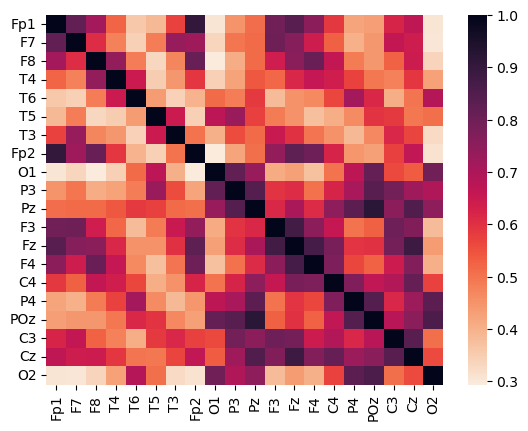

In [193]:


sns.heatmap(corr_hc, cmap=cmap, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

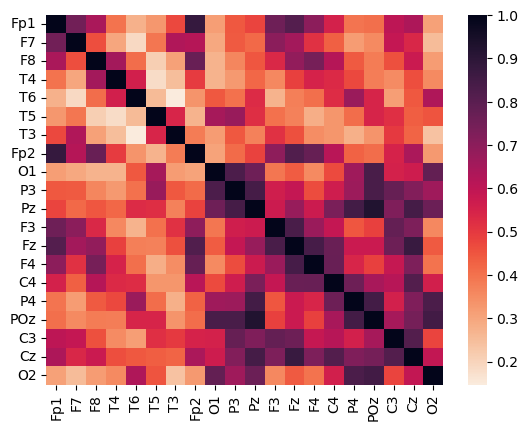

In [192]:
sns.heatmap(corr_ad, cmap=cmap, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

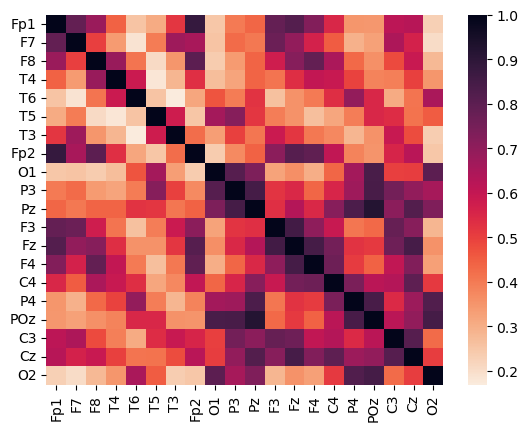

In [140]:
sns.heatmap(corr_mci, cmap=cmap, vmax=1, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

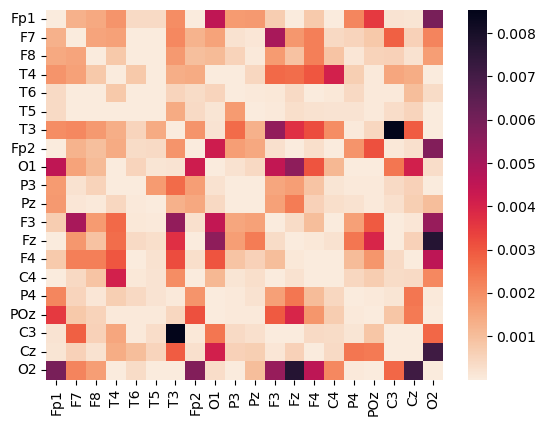

In [173]:
sns.heatmap((corr_mci-corr_ad)**2, cmap=cmap, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

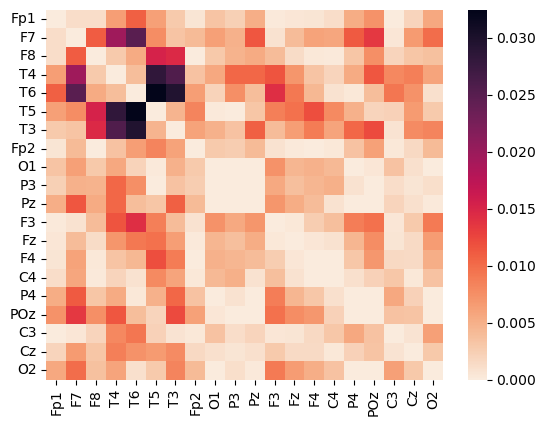

In [101]:
sns.heatmap((corr_mci-corr_hc)**2, cmap=cmap, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

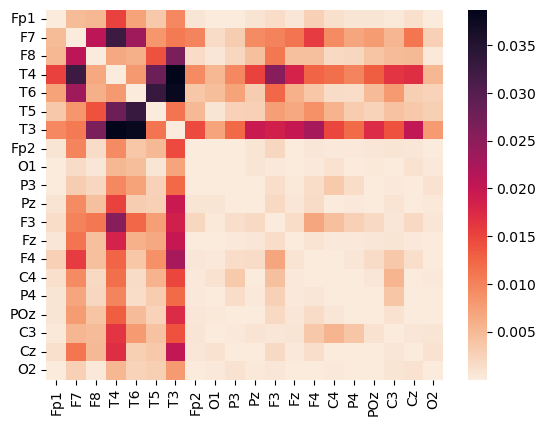

In [95]:
sns.heatmap((corr_hc-corr_ad)**2, cmap=cmap, xticklabels=channels, yticklabels=channels)

In [155]:
ad_corrs = np.stack(new_df[new_df["Condition"] == "AD"]["Correlation"].ravel())
ad_corrs.shape

hc_corrs = np.stack(new_df[new_df["Condition"] == "HC"]["Correlation"].ravel())
hc_corrs.shape

(6717, 20, 20)

In [187]:
dif_hc = (hc_corrs - corr_hc)**2
dif_hc = dif_hc.reshape((hc_corrs.shape[0], 400))

top_dif_hc = dif_hc.mean(axis = 1).argmin()

In [199]:
dif_ad = (ad_corrs - corr_ad)**2
dif_ad = dif_ad.reshape((ad_corrs.shape[0], 400))

top_dif_ad = dif_ad.mean(axis = 1).sort()

In [200]:
top_dif_ad

<AxesSubplot:>

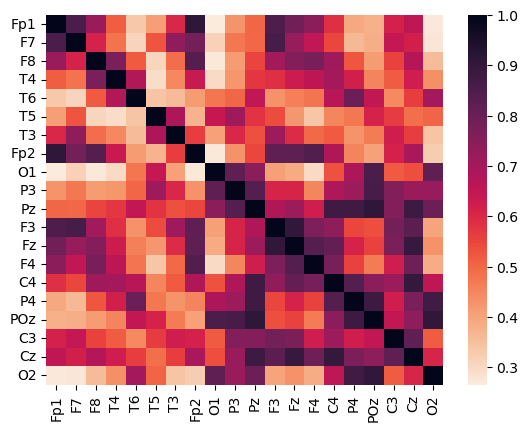

In [188]:
sns.heatmap(hc_corrs[top_dif_hc], cmap=cmap, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

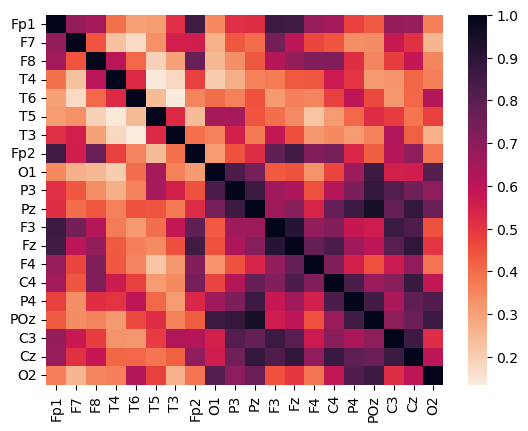

In [189]:
sns.heatmap(ad_corrs[top_dif_ad], cmap=cmap, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

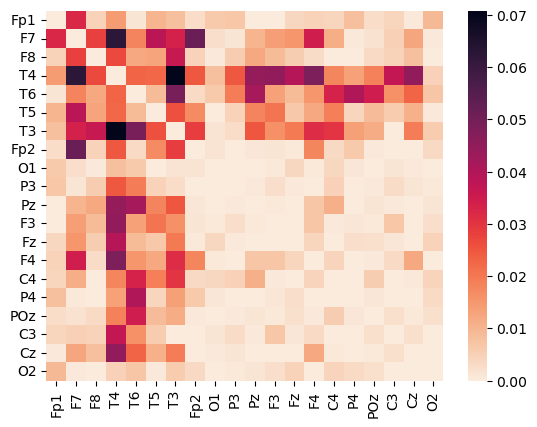

In [195]:
sns.heatmap((ad_corrs[top_dif_ad] - hc_corrs[top_dif_hc])**2, cmap=cmap, xticklabels=channels, yticklabels=channels)

# Paper Dataset